# Applying Augmentations to the Data
<br>
<a href="https://colab.research.google.com/github/MTNeuro/MTNeuro/blob/main/notebooks/applying_augmentations.ipynb">
    <img align="left" alt="Open in Colab button" src="https://colab.research.google.com/assets/colab-badge.svg" width="150" height="60">
</a>
<br>                              

This **MTNeuro** jupyter notebook takes you through how you can easily apply augmentations to the data fetched from BossDB using the provided `BossDBDataset` class. This is explained in the context of both `Task 1` and `Task 2`.

For more details on the tasks and dataset, please refer to our paper:

    "Quesada, J., Sathidevi, L., Liu, R., Ahad, N., Jackson, J.M., Azabou, M., ... & Dyer, E. L. (2022). MTNeuro: A Benchmark for Evaluating Representations of Brain Structure Across Multiple Levels of Abstraction. Thirty-sixth Conference on Neural Information Processing Systems Datasets and Benchmarks Track."


## Clone and install `mtneuro` library along with dependencies

In [ ]:
!git clone https://github.com/MTNeuro/MTNeuro && cd MTNeuro && pip install .
%cd MTNeuro

## Import the required libraries and the `BossDBDataset` class

`BossDBDataset` class acts as the interface that fetches 3D volumes from `BossDB` and presents it to the user as an indexable collection of 2D slices.

In [2]:
import matplotlib.pyplot as plt
import json as json
import os

from MTNeuro.bossdbdataset import BossDBDataset

### Task 1:
Task 1 is a classification task, where the aim is to predict the brain region to which a given slice belongs. So we only need to augment the image. We can use the `image_transform` argument for that purpose.

In [3]:
# loading configuration file for task 1
root = "./MTNeuro/"
with open(os.path.join(root, f"taskconfig/task1.json")) as file:
    task_config = json.load(file)

`torchvision` provides a lot of augmentations that we can use
See [Documentation](https://pytorch.org/vision/stable/transforms.html#transforms-on-pil-image-and-torch-tensor). Use the `Compose` method to combine the list of augmentations that you require and pass it to the `BossDBDataset` class.


In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation((0,180)),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.2))
])

train_data = BossDBDataset(task_config, mode='train', image_transform = transform)

We can use `matplotlib` and `imshow` to plot a matrix of the augmented images

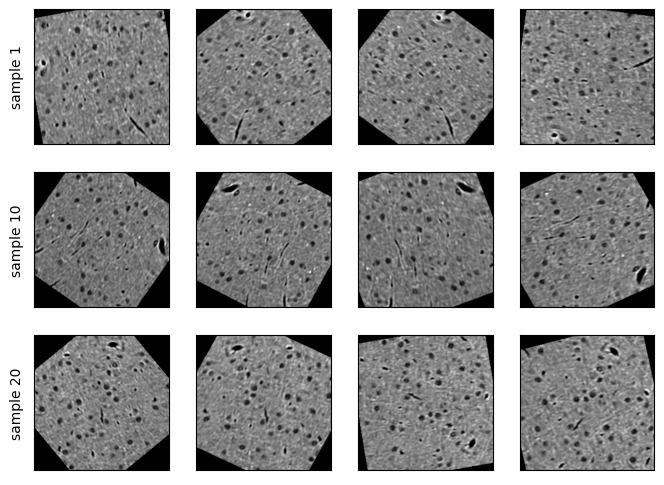

In [5]:
fig, axs = plt.subplots(3, 4, figsize=(8, 6))
for i, sample_id in enumerate([1, 10, 20]):
    axs[i, 0].set_ylabel(f'sample {sample_id}')
    for j in range(4):
        img, y = train_data[sample_id]
        axs[i, j].imshow(img.squeeze(), cmap='gray')
        axs[i, j].set_xticks([]); axs[i, j].set_yticks([])

### Task 2:

For semantic segmentation, we have 2D slices acting as the images as well as 2D annotation slices acting as the labels. So, we need to augment the image slice and its annotation slice (segmentation maps) simultaneously. For this we can make use of functional transforms.
See [Documentation](https://pytorch.org/vision/stable/transforms.html#functional-transforms). 

Note that the tranformation that happens to the annotation slice should be exactly same as the transformation that happens to the image slice.

In [6]:
## Load the task config for 2D 4-class setting that specifies the x,y ranges to pick from the data for forming the slices
with open(os.path.join(root, f"taskconfig/task2_2D_4class.json")) as file:
    task_config_4class = json.load(file)

In [ ]:
####Specify the required transforms and load the data for task 2
import torchvision.transforms.functional as TF
from torchvision import transforms
import random

def transform(image, mask):

    # Random rotation
    if random.random() > 0.5:
        angle = random.randint(-30, 30)
        image = TF.rotate(image, angle)
        mask = TF.rotate(mask, angle)

    # Random crop
    i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(256, 256))
    image = TF.crop(image, i, j, h, w)
    mask = TF.crop(mask, i, j, h, w)

    # Random horizontal flipping
    if random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

    return image, mask

##Set-up the train dataloader and validation dataloader for 4-class
task_config = task_config_4class
train_data = BossDBDataset(task_config, mode='train', transform=transform)

label_names = ["BG", "cell", "BV", "axon"]

Using `matplotlib` and `imshow` to visualize the results

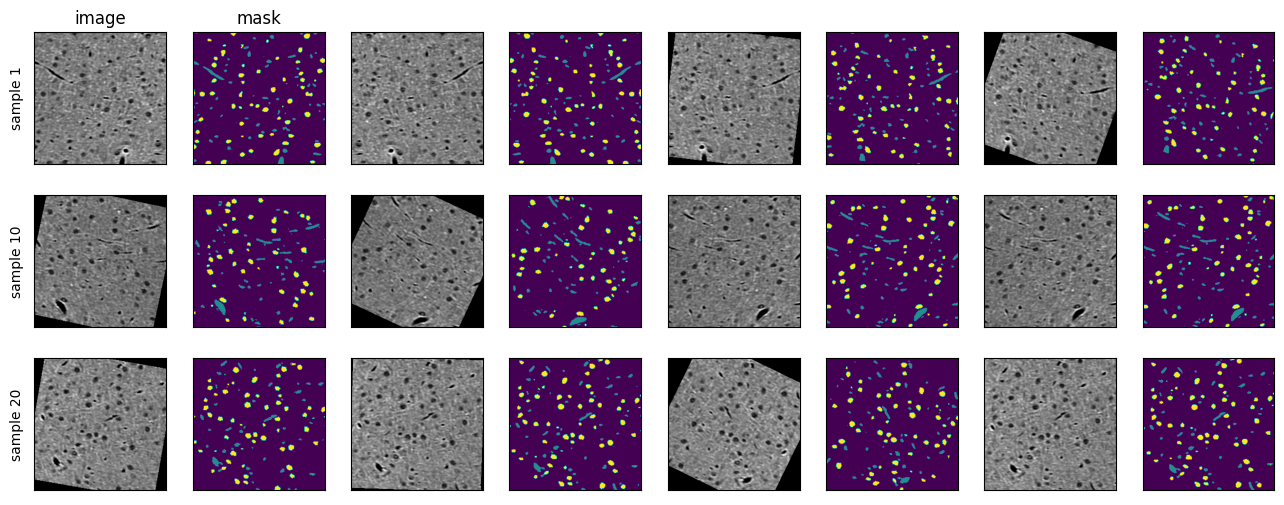

In [8]:
fig, axs = plt.subplots(3, 8, figsize=(16, 6))
for i, sample_id in enumerate([1, 10, 20]):
    axs[i, 0].set_ylabel(f'sample {sample_id}')
    for j in range(0, 8, 2):
        img, mask = train_data[sample_id]
        axs[i, j].imshow(img.squeeze(), cmap='gray')
        axs[i, j+1].imshow(mask.squeeze())
        axs[i, j].set_xticks([]); axs[i, j].set_yticks([])
        axs[i, j+1].set_xticks([]); axs[i, j+1].set_yticks([])

axs[0, 0].set_title('image')
axs[0, 1].set_title('mask')
plt.show()